<a href="https://colab.research.google.com/github/wooje-jung/class-project/blob/main/%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8_%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np

In [2]:
UNIT = '1'
MARKET = 'KRW-BTC'

data_columns = {
    'market': 'Market',
    'candle_date_time_utc': 'Date',
    'opening_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'trade_price': 'Close',
    'candle_acc_trade_volume': 'Volume',
    'candle_acc_trade_price' : 'Price',
}

# str UTC DATETIME
def get_query_datetime():
    now = datetime.datetime.now() #- datetime.timedelta(hours=9)
    now = str(now.strftime('%Y-%m-%d %H:%M:%S'))
    now = now.replace(' ', 'T') + 'Z'
    return now


# 크롤링한 데이터 전처리
def preprocessing_crawled_data(datas: str):
    array_dict_datas = []
    array_datas = datas.split('},')

    for data in array_datas:
        array_data = []
        data = data.replace('{', '')
        data = data.replace('}', '')
        array_data = data.split(',')

        dict_data = {}
        for value in array_data:
            tmp = value.split(':', 1)
            if tmp[0][1: -1] in data_columns:
                dict_data[data_columns[tmp[0][1: -1]]] = tmp[1]

        dict_data['Market'] = dict_data['Market'][1: -1]
        dict_data['Date'] = dict_data['Date'][1: -1]
        dict_data['Open'] = float(dict_data['Open'])
        dict_data['High'] = float(dict_data['High'])
        dict_data['Low'] = float(dict_data['Low'])
        dict_data['Close'] = float(dict_data['Close'])
        dict_data['Volume'] = float(dict_data['Volume'])
        dict_data['Price'] = float(dict_data['Price'])
        array_dict_datas.append(dict_data)

    return array_dict_datas


# 크롤링 후 df 리턴
def do_crawl(unit: str, market: str, time: str, count: str, loop: int):
    df = pd.DataFrame([], columns=['Date', 'Market', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price'])
    url = "https://api.upbit.com/v1/candles/minutes/" + unit

    for _ in range(loop):
        querystring = {"market": market, "to": time, "count": count}
        response = requests.request("GET", url, params=querystring)
        df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
        time = df.iloc[-1]['Date'] + 'Z'
    df = df.loc[::-1].reset_index(drop=True)
    return df




# first 데이터 셋 만들기
df = do_crawl(UNIT, MARKET, get_query_datetime(), '200', 50)
df.to_csv("test.csv")

print(df)

<ipython-input-2-0f85891e40af>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
<ipython-input-2-0f85891e40af>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
<ipython-input-2-0f85891e40af>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
<ipython-input-2-0f85891e40af>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_

                     Date   Market        Open        High         Low  \
0     2023-11-09T13:34:00  KRW-BTC  49211000.0  49211000.0  49190000.0   
1     2023-11-09T13:35:00  KRW-BTC  49199000.0  49199000.0  49151000.0   
2     2023-11-09T13:36:00  KRW-BTC  49168000.0  49184000.0  49168000.0   
3     2023-11-09T13:37:00  KRW-BTC  49184000.0  49189000.0  49179000.0   
4     2023-11-09T13:38:00  KRW-BTC  49179000.0  49180000.0  49167000.0   
...                   ...      ...         ...         ...         ...   
9995  2023-11-16T12:09:00  KRW-BTC  49951000.0  49960000.0  49914000.0   
9996  2023-11-16T12:10:00  KRW-BTC  49959000.0  49999000.0  49950000.0   
9997  2023-11-16T12:11:00  KRW-BTC  49981000.0  49997000.0  49962000.0   
9998  2023-11-16T12:12:00  KRW-BTC  49967000.0  49975000.0  49962000.0   
9999  2023-11-16T12:13:00  KRW-BTC  49973000.0  49973000.0  49959000.0   

           Close     Volume         Price  
0     49190000.0   9.442465  4.645940e+08  
1     49171000.0   9.92

<ipython-input-2-0f85891e40af>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)


Text(0, 0.5, 'price')

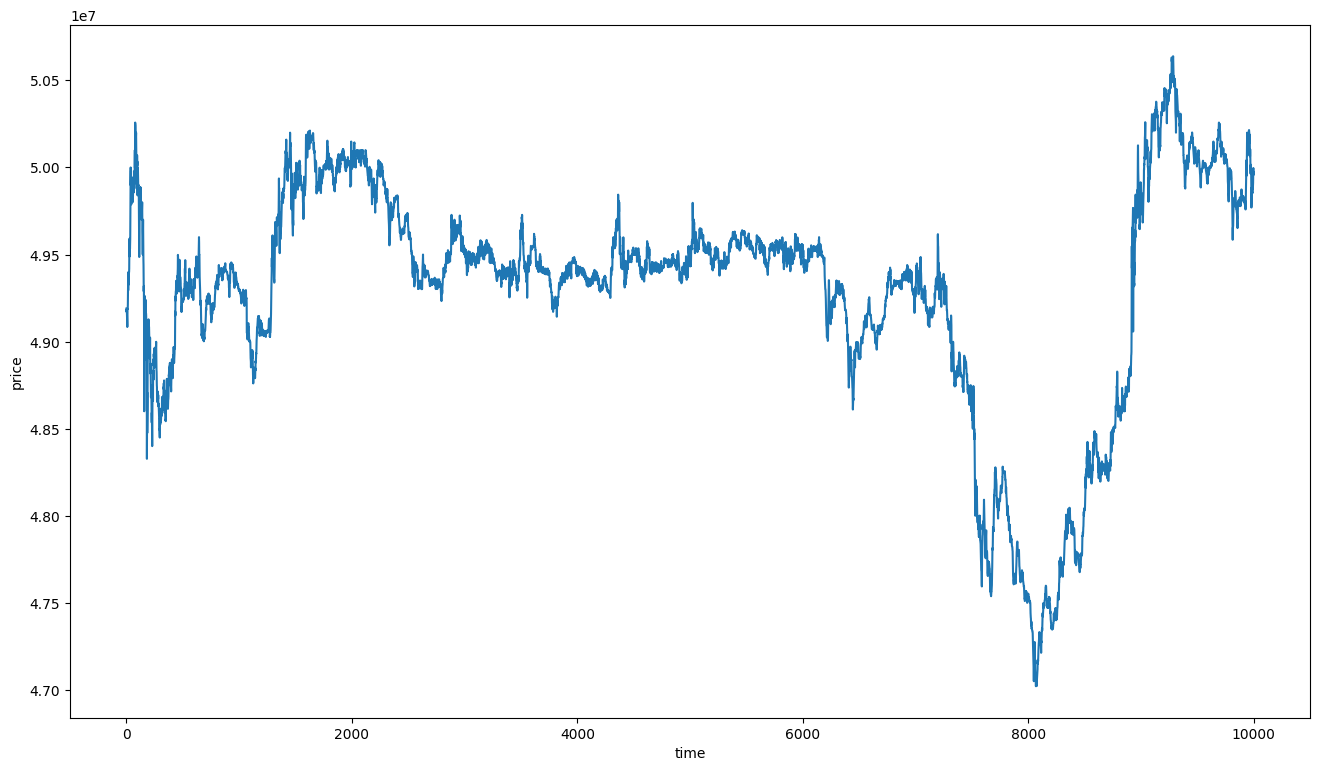

In [4]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [5]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

          Open      High       Low     Close    Volume     Price
0     0.605198  0.602921  0.602497  0.599502  0.057645  0.056776
1     0.601880  0.599614  0.591678  0.594251  0.060611  0.059656
2     0.593309  0.595481  0.596394  0.597844  0.065649  0.064619
3     0.597733  0.596859  0.599445  0.596739  0.032357  0.031855
4     0.596351  0.594379  0.596117  0.596186  0.046317  0.045595
...        ...       ...       ...       ...       ...       ...
9995  0.809787  0.809314  0.803329  0.812051  0.006614  0.006613
9996  0.811999  0.820061  0.813315  0.822554  0.018634  0.018636
9997  0.818081  0.819510  0.816644  0.812880  0.006061  0.006064
9998  0.814211  0.813447  0.816644  0.816197  0.005331  0.005332
9999  0.815870  0.812896  0.815811  0.812327  0.003700  0.003700

[10000 rows x 6 columns]


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.1, random_state=0, shuffle=False)
x_train.shape, y_train.shape
print(type(x_test))
print(x_test)

<class 'pandas.core.frame.DataFrame'>
          Open      High       Low    Volume     Price
9000  0.767487  0.782309  0.771151  0.034255  0.034159
9001  0.784075  0.781207  0.775589  0.051493  0.051389
9002  0.772187  0.778727  0.771706  0.010338  0.010311
9003  0.772187  0.780105  0.775312  0.022780  0.022719
9004  0.782969  0.780105  0.778363  0.003319  0.003312
...        ...       ...       ...       ...       ...
9995  0.809787  0.809314  0.803329  0.006614  0.006613
9996  0.811999  0.820061  0.813315  0.018634  0.018636
9997  0.818081  0.819510  0.816644  0.006061  0.006064
9998  0.814211  0.813447  0.816644  0.005331  0.005332
9999  0.815870  0.812896  0.815811  0.003700  0.003700

[1000 rows x 5 columns]


<ipython-input-6-046d376da86f>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.1, random_state=0, shuffle=False)


In [7]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [8]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [9]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [10]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 5]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [11]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=1000,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
    276/Unknown - 5s 7ms/step - loss: 0.0196 - mse: 0.0393
Epoch 1: val_loss improved from inf to 0.00607, saving model to tmp/ckeckpointer.ckpt
282/282 [==============================] - 6s 10ms/step - loss: 0.0193 - mse: 0.0386 - val_loss: 0.0061 - val_mse: 0.0121
Epoch 2/1000
280/282 [============================>.] - ETA: 0s - loss: 1.9985e-04 - mse: 3.9969e-04
Epoch 2: val_loss improved from 0.00607 to 0.00062, saving model to tmp/ckeckpointer.ckpt
282/282 [==============================] - 3s 10ms/step - loss: 1.9932e-04 - mse: 3.9864e-04 - val_loss: 6.1858e-04 - val_mse: 0.0012
Epoch 3/1000
282/282 [==============================] - ETA: 0s - loss: 1.1733e-04 - mse: 2.3466e-04
Epoch 3: val_loss improved from 0.00062 to 0.00023, saving model to tmp/ckeckpointer.ckpt
282/282 [==============================] - 3s 12ms/step - loss: 1.1733e-04 - mse: 2.3466e-04 - val_loss: 2.3051e-04 - val_mse: 4.6101e-04
Epoch 4/1000
275/282 [============================>.] - ETA: 0s - 

In [12]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0000378
32/32 [==============================] - 1s 10ms/step
(995, 1)
(995, 1)


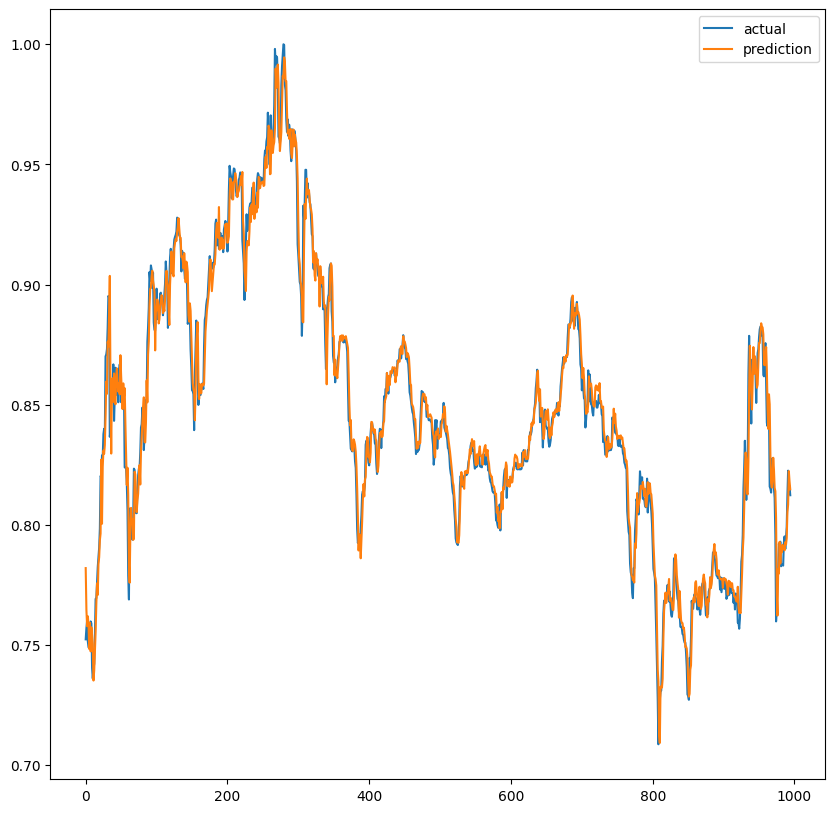

In [13]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()